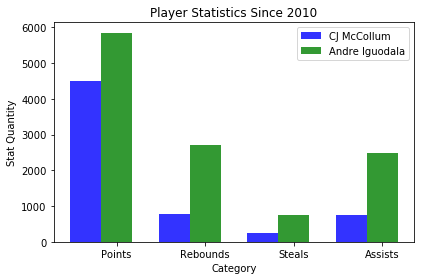

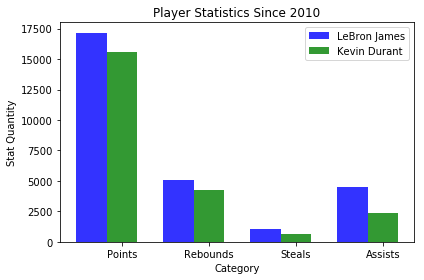

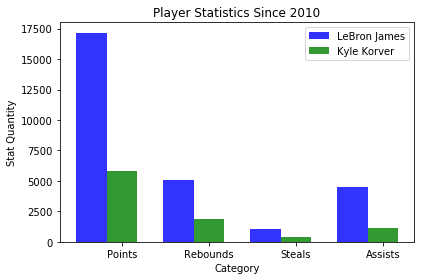

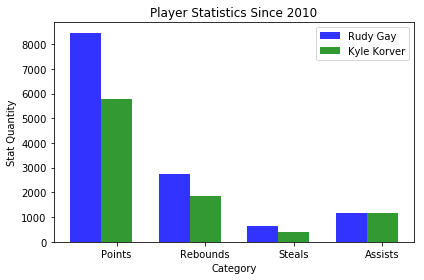

In [ ]:
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox as m
import requests
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

API_KEY = "kXBAdMeKfOwS7WzolGrPDHtpITxQqZ5n"
STAT_URL = "http://api.probasketballapi.com/player?api_key=%s" % API_KEY
DATA_URL = "http://api.probasketballapi.com/boxscore/player?api_key=%s" % API_KEY + "&player_id=%s"
 
class App(tk.Tk):

    def __init__(self):

        tk.Tk.__init__(self)
        self.wm_title("Player Analysis Since 2010")
        self.columnconfigure(0, weight=1)
        self.columnconfigure(1, weight=1)

        self.player_ids = {}
        self.get_player_names()
        self.player_names = list(self.player_ids.keys())

        tk.Label(self, text='Player One').\
            grid(row=0, column=0, sticky="nsew")
        tk.Label(self, text='Player Two').\
            grid(row=1, column=0, sticky="nsew")
        self.player_one = ttk.Combobox(self, state='readonly',
            values=self.player_names)
        self.player_two = ttk.Combobox(self, state='readonly',
            values=self.player_names)
        self.player_one.grid(row=0, column=1, sticky="nsew")
        self.player_two.grid(row=1, column=1, sticky="nsew")

        
        self.player_one.current(0)
        self.player_two.current(1)

        self.init_player_stats()

        self.compare = tk.Button(self, text='Compare Players',
            command=self.compare_players)
        self.compare.grid(row=3, column=0, 
            columnspan=2, sticky="nsew")

    def init_player_stats(self):

        self.player_one_stats = {
            'points': 0,
            'rebounds': 0,
            'steals': 0,
            'assists': 0,
        }
        self.player_two_stats = {
            'points': 0,
            'rebounds': 0,
            'steals': 0,
            'assists': 0,
        }

    def display_bar_graph(self):

        n_groups = 4
        p1_data = (
            self.player_one_stats['points'], 
            self.player_one_stats['rebounds'],
            self.player_one_stats['steals'],
            self.player_one_stats['assists']
        )
        p2_data = (
            self.player_two_stats['points'], 
            self.player_two_stats['rebounds'],
            self.player_two_stats['steals'],
            self.player_two_stats['assists']
        )
         
        fig, ax = plt.subplots()
        index = np.arange(n_groups)
        bar_width = 0.35
        opacity = 0.8
         
        rects1 = plt.bar(index, p1_data, bar_width,
                         alpha=opacity, color='b',
                         label=self.player_one.get())
         
        rects2 = plt.bar(index + bar_width, p2_data, bar_width,
                         alpha=opacity, color='g',
                         label=self.player_two.get())
         
        plt.xlabel('Category')
        plt.ylabel('Stat Quantity')
        plt.title('Player Statistics Since 2010')
        plt.xticks(index + bar_width, 
            ('Points', 'Rebounds', 'Steals', 'Assists'))
        plt.legend()
         
        plt.tight_layout()
        plt.show()

    def get_player_names(self):

        r = requests.post(STAT_URL)
        for item in r.json():
            self.player_ids[item['player_name']] = {'id': item['id'],
                'team_id': item['team_id'],
            }

    def get_id(self, stringvar):

        return self.player_ids[stringvar.get()]['id']

    def get_post(self, stringvar):

        r = requests.post(DATA_URL % self.get_id(stringvar))
        return r.json()

    def sum_stats(self, player_json, player_dict):

        for item in player_json:
            stl = int(item['stl'] or 0)
            reb = int(item['dreb'] or 0)
            reb += int(item['oreb'] or 0)
            pts = int(item['pts'] or 0)
            ast = int(item['ast'] or 0)
            getattr(self, player_dict)['points'] += pts
            getattr(self, player_dict)['rebounds'] += reb
            getattr(self, player_dict)['steals'] += stl
            getattr(self, player_dict)['assists'] += ast
        pts = getattr(self, player_dict)['points']
        rbnds = getattr(self, player_dict)['rebounds']
        stls = getattr(self, player_dict)['steals']
        asts = getattr(self, player_dict)['assists']
        _sum = pts + rbnds + stls + asts
        return _sum

    def compare_stats(self):

        p1_json = self.get_post(self.player_one)
        p2_json = self.get_post(self.player_two)
        p1_sum = self.sum_stats(p1_json, "player_one_stats")
        p2_sum = self.sum_stats(p2_json, "player_two_stats")
        if p1_sum > p2_sum:
            m.showinfo("Results", self.player_one.get() + 
                " is better with a total fantasy score of %d." % p1_sum)
        else:
            m.showinfo("Results", self.player_two.get() + 
                " is better with a total fantasy score of %d." % p2_sum)
        self.display_bar_graph()

    def compare_players(self):

        if self.player_one.get() == self.player_two.get():
            m.showerror("Invalid Input!",
                "You must enter two different players!")
        else:
            self.init_player_stats()
            self.compare_stats()

if __name__ == '__main__':

    app = App()
    app.mainloop()